# Lab 5 Zespoły klasyfikatorów

In [1]:
# Imports
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, DBSCAN
from ydata_profiling import ProfileReport
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

Dataset pochodzi z kaggle i zawiera dane o sprzedaży gier wideo:


https://www.kaggle.com/datasets/sidtwr/videogames-sales-dataset?select=Video_Games_Sales_as_at_22_Dec_2016.csv

In [2]:
raw_df = pd.read_csv("../dbs/VideoGamesSales.csv")
raw_df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


## Kolumny w zbiorze danych


In [3]:
# Podział danych na zbiór treningowy i testowy
train_data, test_data = train_test_split(raw_df, test_size=0.2, random_state=42)

df = train_data.copy()

In [4]:
# AutoEDA
profile = ProfileReport(df, title="VideoGamesSales", explorative=True)
profile.to_file("game_sales_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/ydata_profiling/model/correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'Sports'')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

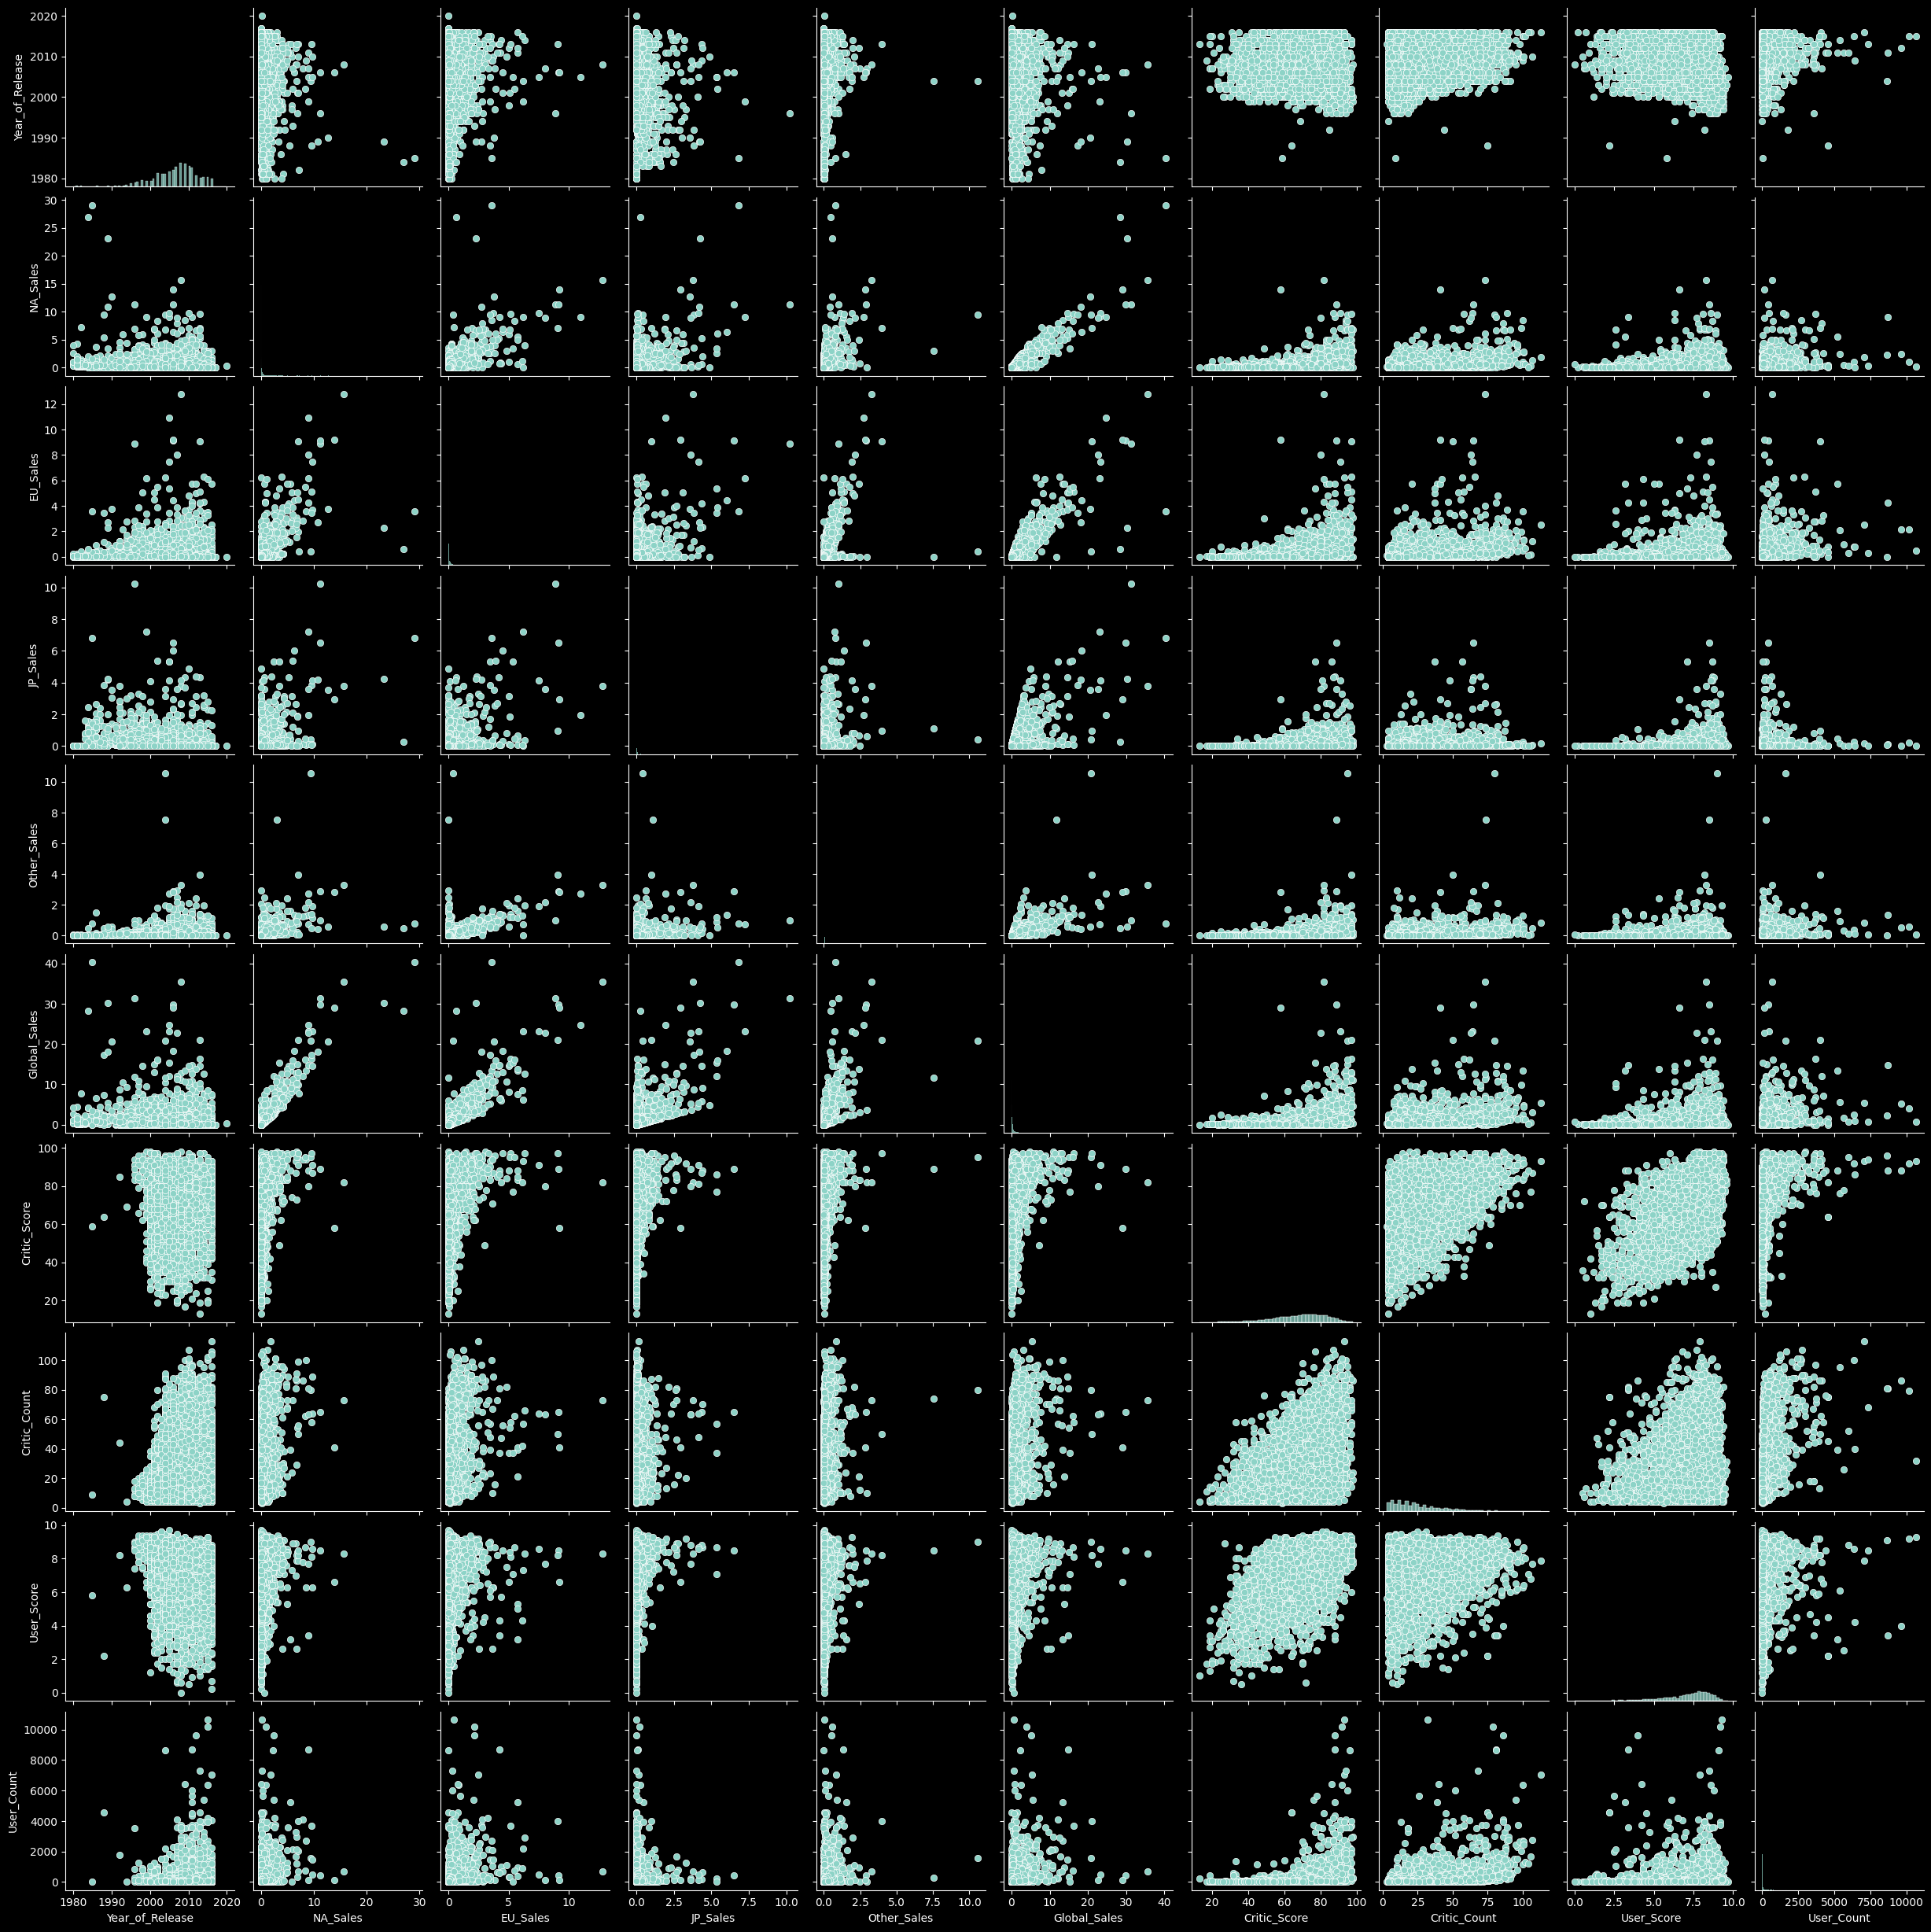

In [5]:
sns.pairplot(df)
plt.show()

In [6]:
df.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,13164.000000,13375.000000,13375.000000,13375.000000,13375.000000,13375.000000,6507.000000,6507.000000,6065.000000,6065.000000
mean,2006.492859,0.260228,0.142113,0.076176,0.046770,0.525554,68.931151,26.409098,7.119060,159.203957
std,5.870260,0.754561,0.441869,0.308149,0.180931,1.400984,13.941300,18.997901,1.500913,536.138868
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,0.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,6.400000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,21.000000,7.500000,24.000000
75%,2010.000000,0.240000,0.110000,0.030000,0.030000,0.470000,79.000000,36.000000,8.200000,81.000000
max,2020.000000,29.080000,12.760000,10.220000,10.570000,40.240000,98.000000,113.000000,9.700000,10665.000000


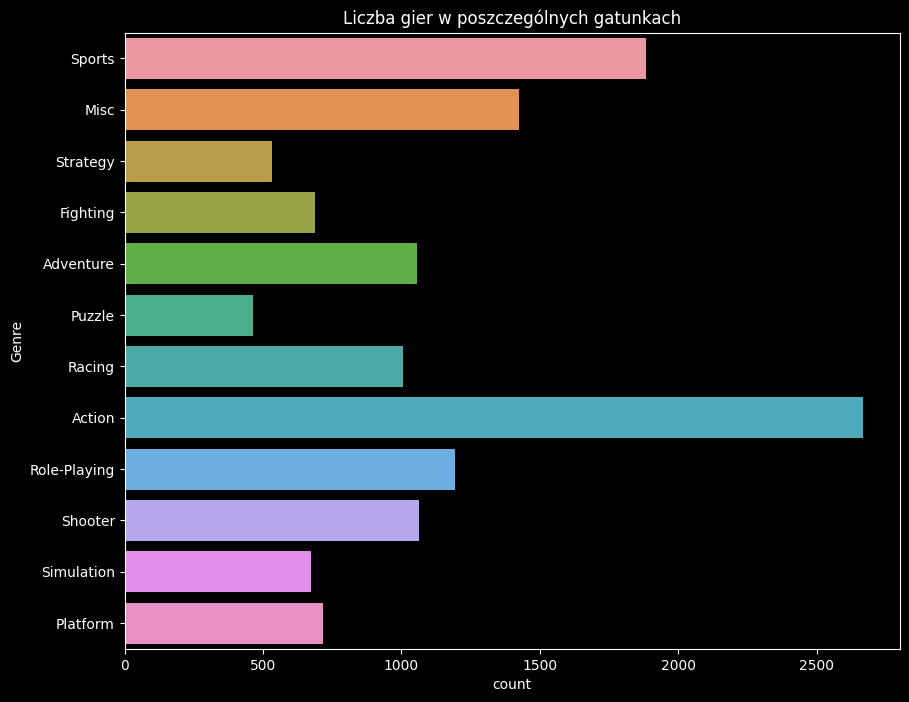

In [12]:
plt.figure(figsize=(10, 8))
sns.countplot(y='Genre', data=df)
plt.title('Liczba gier w poszczególnych gatunkach')
plt.show()

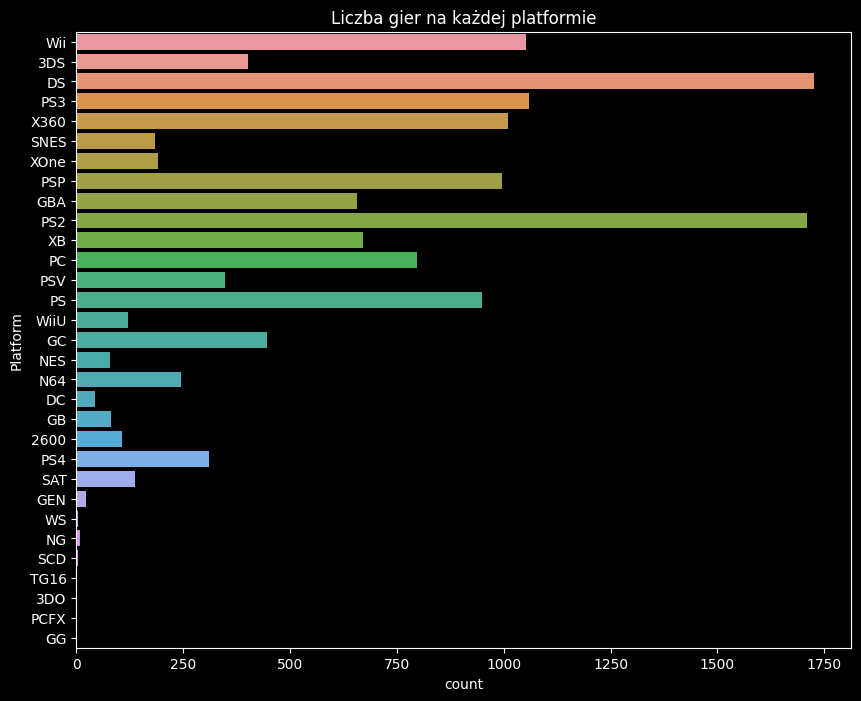

In [13]:
plt.figure(figsize=(10, 8))
sns.countplot(y='Platform', data=df)
plt.title('Liczba gier na każdej platformie')
plt.show()

## Wnioski EDA
Super zbiór, nie ma brakujących danych, powtarzających się wierszy itp.

Jedna kolumna kategoryczna: Sex

In [7]:
# Konwersja kategorii 'Sex' na zmienne numeryczne
# df = pd.get_dummies(df, columns=['Sex'])

In [8]:
# # Standaryzacja danych
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(df)

# data_scaled = pd.DataFrame(scaled_features, columns=df.columns[:])

In [9]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
iso_forest.fit(data_scaled)

# Predykcja outlierów
outliers_pred = iso_forest.predict(data_scaled)

# Oznaczanie outlierów w zbiorze danych
data_scaled['outlier'] = outliers_pred
outliers = data_scaled[data_scaled['outlier'] == -1]

clean_data = data_scaled[data_scaled['outlier'] == 1]

print("Wykryto outlierów:", len(outliers))
print("Liczba rekordów po usunięciu outlierów:", clean_data.shape[0])


NameError: name 'data_scaled' is not defined

In [ ]:
clean_data.drop('outlier', axis=1, inplace=True)
clean_data.head()

/var/folders/ld/46j6jly10md36dbxgn_h72br0000gn/T/ipykernel_64019/2784651732.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data.drop('outlier', axis=1, inplace=True)


,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
0,0.210175,0.369725,-0.347950,-0.323164,-0.325407,-0.405130,-0.212132,0.329098,-0.67464,1.451863,-0.758909
1,-0.419444,-0.542386,-0.936082,-0.665985,-0.480126,-0.820932,-0.712419,-0.606395,-0.67464,1.451863,-0.758909
3,-2.098428,-2.113245,-1.759467,-1.453355,-1.363597,-1.533734,-1.462848,-0.918227,-0.67464,1.451863,-0.758909
4,-0.251546,-0.289022,-0.112697,-0.409632,-0.437522,-0.350299,-0.176398,0.640929,-0.67464,-0.688770,1.317680
5,-0.167597,-0.289022,-0.465577,-0.481859,-0.453219,-0.341161,-0.426541,-0.918227,-0.67464,1.451863,-0.758909


# Uruchomienie algorytmów grupowania

In [ ]:
# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(clean_data)

In [ ]:

# Ewaluacja K-Means
print("K-Means Silhouette Score: ", silhouette_score(clean_data, kmeans_labels))
print("K-Means Davies-Bouldin Score: ", davies_bouldin_score(clean_data, kmeans_labels))
print("K-Means Calinski-Harabasz Score: ", calinski_harabasz_score(clean_data, kmeans_labels))

K-Means Silhouette Score:  0.400341505297753
K-Means Davies-Bouldin Score:  1.0349723681038963
K-Means Calinski-Harabasz Score:  2227.377504538851


In [ ]:

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(clean_data)

In [ ]:

# Ewaluacja DBSCAN
print("DBSCAN Silhouette Score: ", silhouette_score(clean_data, dbscan_labels))
print("DBSCAN Davies-Bouldin Score: ", davies_bouldin_score(clean_data, dbscan_labels))
print("DBSCAN Calinski-Harabasz Score: ", calinski_harabasz_score(clean_data, dbscan_labels))


DBSCAN Silhouette Score:  0.0028394970330076243
DBSCAN Davies-Bouldin Score:  1.4405206451808217
DBSCAN Calinski-Harabasz Score:  270.7832648133524


/var/folders/ld/46j6jly10md36dbxgn_h72br0000gn/T/ipykernel_64019/1284046835.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual_data['KMeans_Labels'] = kmeans_labels
/var/folders/ld/46j6jly10md36dbxgn_h72br0000gn/T/ipykernel_64019/1284046835.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual_data['DBSCAN_Labels'] = dbscan_labels


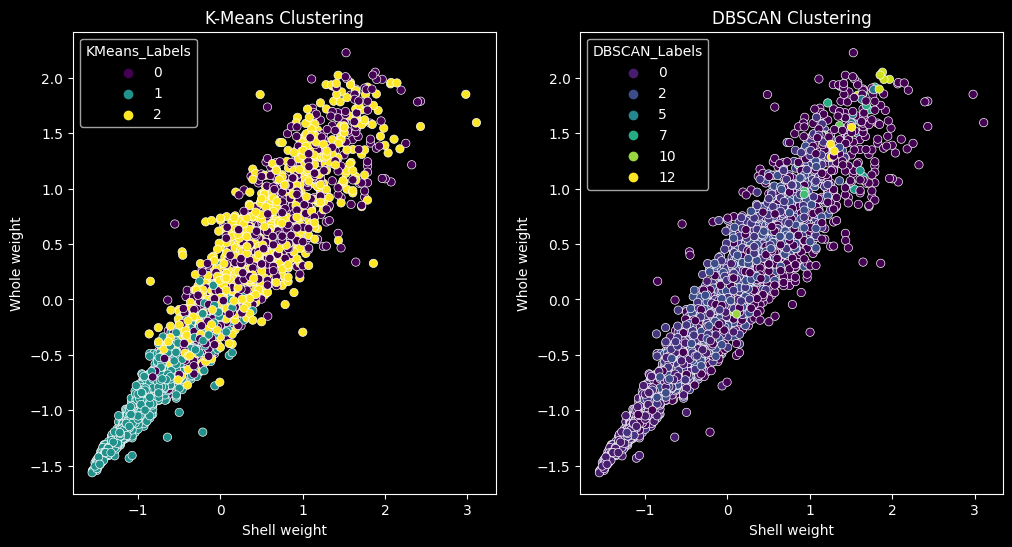

In [ ]:
# Wybór zmiennych do wizualizacji
visual_data = clean_data
visual_data['KMeans_Labels'] = kmeans_labels
visual_data['DBSCAN_Labels'] = dbscan_labels

# Wizualizacja dla K-Means
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=visual_data, x='Shell weight', y='Whole weight', hue='KMeans_Labels', palette='viridis')
plt.title('K-Means Clustering')

# Wizualizacja dla DBSCAN
plt.subplot(1, 2, 2)
sns.scatterplot(data=visual_data, x='Shell weight', y='Whole weight', hue='DBSCAN_Labels', palette='viridis')
plt.title('DBSCAN Clustering')

plt.show()


/var/folders/ld/46j6jly10md36dbxgn_h72br0000gn/T/ipykernel_64019/937309158.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['PCA1'] = pca_result[:, 0]
/var/folders/ld/46j6jly10md36dbxgn_h72br0000gn/T/ipykernel_64019/937309158.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['PCA2'] = pca_result[:, 1]


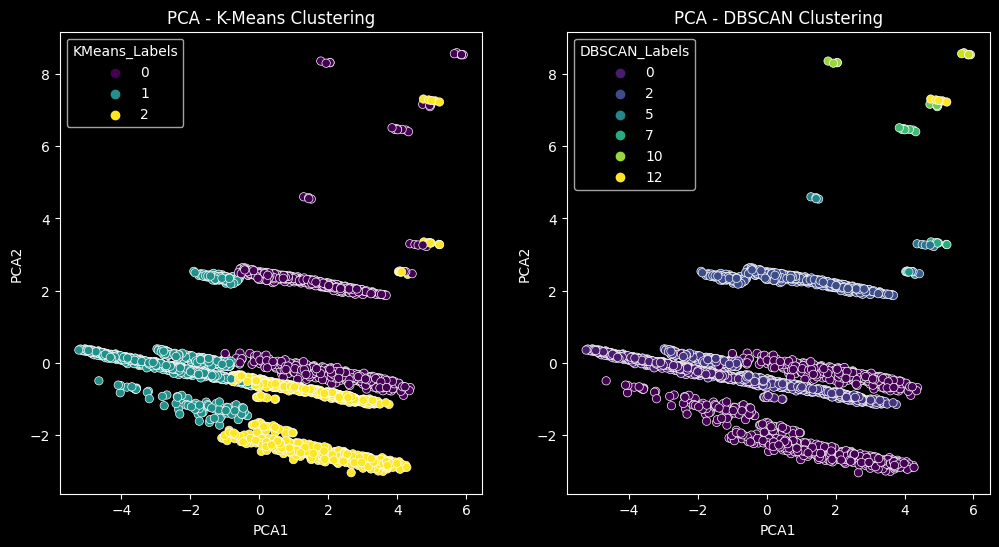

In [ ]:
# Redukcja wymiarowości
pca = PCA(n_components=2)
pca_result = pca.fit_transform(clean_data)

clean_data['PCA1'] = pca_result[:, 0]
clean_data['PCA2'] = pca_result[:, 1]

# Wizualizacja PCA dla K-Means
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=clean_data['PCA1'], y=clean_data['PCA2'], hue=visual_data['KMeans_Labels'], palette='viridis')
plt.title('PCA - K-Means Clustering')

# Wizualizacja PCA dla DBSCAN
plt.subplot(1, 2, 2)
sns.scatterplot(x=clean_data['PCA1'], y=clean_data['PCA2'], hue=visual_data['DBSCAN_Labels'], palette='viridis')
plt.title('PCA - DBSCAN Clustering')

plt.show()
